In [14]:
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

Giả sử chúng ta sẽ build một model mà training data là các giá trị được tạo ta từ hàm:
  $$y = x^2 \tag{1}$$

Ta sẽ định nghĩa (1) trong `calculate()`.

In [3]:
def calculate(x):
    return x*x

Định nghĩa một `inputs` và dùng hàm `calculate()` để xác định cho `outputs`.

In [5]:
inputs = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
outputs = [calculate(input) for input in inputs]

print(outputs)

[0.25, 0.16000000000000003, 0.09, 0.04000000000000001, 0.010000000000000002, 0, 0.010000000000000002, 0.04000000000000001, 0.09, 0.16000000000000003, 0.25]


Trực quan hóa.

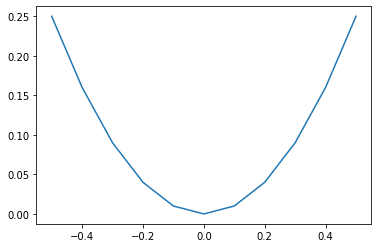

In [6]:
plt.plot(inputs, outputs)
plt.show()

Bây giờ chúng ta sẽ tạo hàm `generate_samples()` dùng để phát sinh các **input** cho GANs model.

In [10]:
def generate_samples(n=100):
    '''Phát sinh @n giá trị trong khoảng [-0.5, 0.5]'''
    X1 = np.random.rand(n) - 0.5
    
    '''Tạo output từ @X1'''
    X2 = X1 * X1
    
    '''Reshape lại thành mảng chứa @n mảng gồm 1 phần tử'''
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    
    '''Trả về một np-array có shape=(@n, 2)'''
    return np.hstack((X1, X2))

Bây giờ ta sẽ phát sinh 100 giá trị đầu vào bằng hàm `generate_samples()`.

In [11]:
data = generate_samples()

print(data)

[[ 3.99468550e-01  1.59575123e-01]
 [-2.15220832e-01  4.63200067e-02]
 [ 3.26957188e-01  1.06901003e-01]
 [-3.80354524e-01  1.44669564e-01]
 [ 3.04135944e-01  9.24986722e-02]
 [-2.12147490e-02  4.50065574e-04]
 [ 4.08996933e-01  1.67278491e-01]
 [ 2.73878702e-01  7.50095434e-02]
 [ 3.69553751e-01  1.36569975e-01]
 [ 2.95046649e-01  8.70525251e-02]
 [-7.26559007e-02  5.27887990e-03]
 [-2.26372446e-02  5.12444843e-04]
 [ 4.00541906e-01  1.60433818e-01]
 [ 8.99828197e-02  8.09690783e-03]
 [-5.15662236e-02  2.65907542e-03]
 [ 2.43601866e-01  5.93418690e-02]
 [-2.66877440e-01  7.12235682e-02]
 [ 2.95557427e-01  8.73541927e-02]
 [ 3.99109373e-01  1.59288292e-01]
 [ 2.86896074e-01  8.23093574e-02]
 [-5.22019537e-02  2.72504397e-03]
 [ 3.90192159e-01  1.52249921e-01]
 [ 8.94681321e-02  8.00454667e-03]
 [-1.44659792e-01  2.09264554e-02]
 [-2.60405680e-01  6.78111181e-02]
 [ 2.61238355e-01  6.82454783e-02]
 [ 1.43798469e-01  2.06779997e-02]
 [ 5.18841720e-03  2.69196730e-05]
 [ 2.70728879e-01  7

Trực quan hóa `data`.

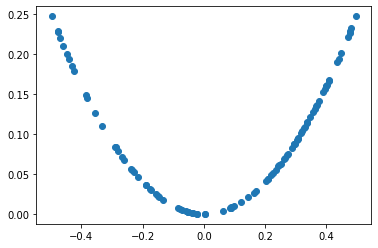

In [13]:
plt.scatter(data[:, 0], data[:, 1])
plt.show()

Bây giờ chúng ta sẽ build Discriminator model.

Ở bài toán của chúng ta, Discriminator model nhận vào một giá trị và nó phải dự đoán xem giá trị này là real hay fake, nói cách khác Discriminator là một binary classifier, trong đó:
  * **Inputs**: là hai số thực.
  * **Outputs**:  phân loại nhị phân, cụ thể dự đoán một sample là real hay fake.

Chúng ta sẽ xây dựng kiến trúc cho Discriminator bao gồm 1 hidden layer với 25 neuron và dùng ReLU activation function.

Tiếp theo, chúng ta cần xác định **init random noise vector**, chúng ta sẽ khởi tạo vector này bằng một phương pháp là **He weight initialization**.

Output layer sẽ chỉ có 1 neuron và sẽ sử dụng sigmoid activation function.

Loss function mà chúng ta sử dụng sẽ là **binary cross-entropy**.

Optimizer mà chúng ta sẽ sử dụng là **Adam**.

Tiếp theo, metrics mà chúng ta sẽ dùng là **accuracy**.

Chúng ta sẽ bỏ tất cả những thứ này vào một hàm là `define_discriminator()`.

In [16]:
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    
    '''Biên dịch model'''
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

Bây giờ chúng ta sẽ tạo Discriminator model thông qua hàm `define_discriminator()`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                75        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


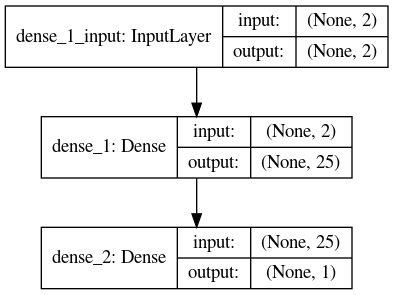

In [17]:
model = define_discriminator()

model.summary()
plot_model(model, to_file='./images/discriminator_plot.png',
           show_shapes=True, show_layer_names=True)

Bây giờ ta sẽ định nghĩa hàm `generate_real_sample()`, hàm này dùng để phát sinh các real sample, tức có label là $1$.

In [19]:
def generate_real_samples(n):
    X1 = np.random.rand(n) - 0.5
    X2 = X1*X1
    
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    
    X = np.hstack((X1, X2))
    y = np.ones((n, 1))
    
    return X, y

Tiếp theo, chúng ta sẽ định nghĩa một hàm với chức năng tương tự như hàm `generate_real_samples()` nhưng để phát sinh các fake sample, tức có label bằng $0$.

In [20]:
def generate_fake_samples(n):
    X1 = -1 + np.random.rand(n) * 2
    X2 = -1 + np.random.rand(n) * 2
    
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = np.hstack((X1, X2))
    
    y = np.zeros((n, 1))
    return X, y

In [21]:
def train_discriminator(model, n_epochs=1000, n_batch=128):
    half_batch = n_batch // 2
    
    for i in range(n_epochs):
        X_real, y_real = generate_real_samples(half_batch)
        model.train_on_batch(X_real, y_real)
        
        X_fake, y_fake = generate_fake_samples(half_batch)
        model.train_on_batch(X_fake, y_fake)
        
        _, acc_real = model.evaluate(X_real, y_real, verbose=0)
        _, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
        
        print(i, acc_real, acc_fake)

In [22]:
model = define_discriminator()
train_discriminator(model)

0 0.34375 0.625
1 0.390625 0.640625
2 0.375 0.625
3 0.453125 0.65625
4 0.34375 0.703125
5 0.3125 0.703125
6 0.421875 0.6875
7 0.28125 0.703125
8 0.328125 0.78125
9 0.390625 0.828125
10 0.28125 0.796875
11 0.359375 0.8125
12 0.453125 0.875
13 0.515625 0.765625
14 0.359375 0.9375
15 0.265625 0.875
16 0.21875 0.875
17 0.375 0.875
18 0.3125 0.890625
19 0.203125 0.859375
20 0.34375 0.9375
21 0.28125 0.953125
22 0.28125 0.875
23 0.25 0.96875
24 0.359375 0.875
25 0.234375 0.921875
26 0.46875 0.890625
27 0.40625 0.96875
28 0.3125 0.9375
29 0.28125 0.953125
30 0.359375 0.953125
31 0.328125 0.96875
32 0.3125 0.96875
33 0.3125 0.9375
34 0.1875 0.921875
35 0.234375 0.875
36 0.328125 0.921875
37 0.359375 0.890625
38 0.328125 0.984375
39 0.4375 0.984375
40 0.34375 0.984375
41 0.375 1.0
42 0.3125 0.96875
43 0.296875 0.984375
44 0.296875 1.0
45 0.3125 0.984375
46 0.3125 0.984375
47 0.21875 0.984375
48 0.265625 1.0
49 0.46875 0.984375
50 0.296875 1.0
51 0.328125 1.0
52 0.4375 1.0
53 0.296875 0.953125
5